<a href="https://colab.research.google.com/github/rajy4683/S7EVA4/blob/master/S7EVA4_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip install pytorch-ignite
# !pip install torchsummary
# !pip install wandb

In [2]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
#!pip install git+https://github.com/rajy4683/RekogNizer.git

In [0]:
#!git clone https://github.com/rajy4683/RekogNizer.git /content/drive/My\ Drive/EVA4/TestImports

In [0]:
sys.path.append('/content/drive/My Drive/EVA4/')
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')


In [4]:
from RekogNizer.hyperparams import *
from RekogNizer import basemodelclass
from RekogNizer.fileutils import *
from RekogNizer.dataloader import *
from RekogNizer.traintest import *
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if not hyperparameter_defaults['no_cuda'] else "cpu")


Files already downloaded and verified
Files already downloaded and verified


In [5]:
rand_run_name()

'c91b9c4f8f'

In [6]:
len(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([4, 3, 32, 32])


In [7]:
hyperparameter_defaults['seed']

1

plane   dog  deer  deer


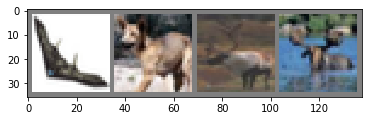

In [8]:
#import torch
get_image_samples(trainloader, classes)

In [0]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        self.layer1_channels = 32
        self.dropout_val = 0.1
        self.bias = False

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.layer1_channels, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels, self.layer1_channels, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels),
            nn.ReLU(),
            # nn.Conv2d(self.layer1_channels, self.layer1_channels, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val))

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.layer1_channels, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*2),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val))

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*4, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*4),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*4),
            nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*4),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val))

        self.conv4 = nn.Sequential(
            nn.Conv2d(self.layer1_channels*4, self.layer1_channels*8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels*8, self.layer1_channels*8, 3, padding=1, stride=1,bias=self.bias),            
            nn.BatchNorm2d(self.layer1_channels*8),
            nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*8),
            # nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val))
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(self.layer1_channels*8, 10, 1, bias=self.bias)
        )

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 5 * 5)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)

        return x

In [0]:


#model = basemodelclass.CIFARModelBuilder()#.to(device)
#summary(model,input_size=(3, 32, 32))
#model_new = CIFARModel().to(device)
#summary(model_new,input_size=(3, 32, 32))



In [23]:
model_new = CIFARModel().to(device)
summary(model_new,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
           Dropout-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
#optimizer.zero_grad()
output = model(images)

In [31]:
output

tensor([[ 0.0054, -0.1331, -0.1049, -0.0413, -0.0328,  0.0552, -0.1212, -0.1326,
          0.0343,  0.0638],
        [ 0.0229, -0.1250, -0.0889, -0.0223, -0.0316,  0.0527, -0.0895, -0.1009,
          0.0306,  0.0625],
        [ 0.0282, -0.1315, -0.0934, -0.0173, -0.0338,  0.0596, -0.0980, -0.1147,
          0.0361,  0.0707],
        [ 0.0145, -0.1354, -0.0915, -0.0329, -0.0419,  0.0546, -0.0907, -0.1101,
          0.0335,  0.0606]], grad_fn=<AddmmBackward>)

In [14]:
type(model_new)

__main__.CIFARModel

In [0]:
def calculate_loss(loss_fn):
    loss = loss_fn#nn.CrossEntropyLoss()
    input = torch.randn(3, 5, requires_grad=True)
    target = torch.empty(3, dtype=torch.long).random_(5)
    output = loss(input, target)
    output.backward()
    print(output.item())

In [0]:
def calc_loss(loss_fn):
    calculate_loss(loss_fn())
    calculate_loss(loss_fn(reduction='sum'))

In [0]:
calc_loss(nn.CrossEntropyLoss)

1.9536319971084595
7.3324174880981445


In [12]:
optimizer=optim.SGD#(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss
#model = basemodelclass.CIFARModelBuilder()#.to(device)
model_new = CIFARModel()#.to(device)
#execute_model(model, hyperparameter_defaults, )
execute_model(model_new, hyperparameter_defaults, 
              trainloader, testloader, 
              device, classes,
              optimizer=optimizer,
              criterion=criterion)

  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.3722, Accuracy: 47.200%
Epoch: 1 Test set: Average loss: 1.0096, Accuracy: 65.010%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.2648, Accuracy: 64.220%
Epoch: 2 Test set: Average loss: 0.7303, Accuracy: 74.940%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.2239, Accuracy: 69.916%
Epoch: 3 Test set: Average loss: 0.6635, Accuracy: 77.100%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.1974, Accuracy: 73.468%
Epoch: 4 Test set: Average loss: 0.5898, Accuracy: 79.830%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.1774, Accuracy: 76.294%
Epoch: 5 Test set: Average loss: 0.5628, Accuracy: 80.870%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.1648, Accuracy: 77.814%
Epoch: 6 Test set: Average loss: 0.5364, Accuracy: 81.810%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.1523, Accuracy: 79.646%
Epoch: 7 Test set: Average loss: 0.5134, Accuracy: 82.510%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.1416, Accuracy: 81.010%
Epoch: 8 Test set: Average loss: 0.5301, Accuracy: 82.040%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.1332, Accuracy: 82.136%
Epoch: 9 Test set: Average loss: 0.4898, Accuracy: 83.540%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.1247, Accuracy: 83.096%
Epoch: 10 Test set: Average loss: 0.4558, Accuracy: 84.700%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.1179, Accuracy: 84.176%
Epoch: 11 Test set: Average loss: 0.4673, Accuracy: 84.240%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.1109, Accuracy: 85.058%
Epoch: 12 Test set: Average loss: 0.4341, Accuracy: 85.110%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.1058, Accuracy: 85.562%
Epoch: 13 Test set: Average loss: 0.4328, Accuracy: 85.090%


  0%|          | 0/12500 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0998, Accuracy: 86.598%
Epoch: 14 Test set: Average loss: 0.4276, Accuracy: 85.400%


loss=0.2672578990459442 batch_id=12499: 100%|██████████| 12500/12500 [02:48<00:00, 68.98it/s]



Epoch: 15 Train set: Average loss: 0.0948, Accuracy: 87.158%
Epoch: 15 Test set: Average loss: 0.4178, Accuracy: 85.510%
